### Loading the packages

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,losses
from tensorflow.keras.models import Model

from tensorflow.keras.datasets import fashion_mnist

### Load the dataset

In [7]:
#
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
# !tar zxvf lfw-deepfunneled.tgz

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
import requests
import tarfile
import os

# URL of the dataset
url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'
file_name = 'lfw-deepfunneled.tgz'

# Download the file
response = requests.get(url, stream=True)
with open(file_name, 'wb') as file:
    for chunk in response.iter_content(chunk_size=1024): 
        if chunk:
            file.write(chunk)

# Extract the file
with tarfile.open(file_name, 'r:gz') as tar:
    tar.extractall()

# Remove the tar file if you no longer need it
os.remove(file_name)

print("Dataset downloaded and extracted successfully.")


Dataset downloaded and extracted successfully.


In [16]:
#!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
# !tar zxvf lfw.tgz



# URL of the new dataset
url = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'
file_name = 'lfw.tgz'

# Download the file
response = requests.get(url, stream=True)
with open(file_name, 'wb') as file:
    for chunk in response.iter_content(chunk_size=1024): 
        if chunk:
            file.write(chunk)

# Extract the file
with tarfile.open(file_name, 'r:gz') as tar:
    tar.extractall()

# Remove the tar file if you no longer need it
os.remove(file_name)

print("Dataset downloaded and extracted successfully.")


Dataset downloaded and extracted successfully.


In [9]:
# # http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
# ATTRS_NAME = "lfw_attributes.txt"

# # http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
# IMAGES_NAME = "lfw-deepfunneled.tgz"

# # http://vis-www.cs.umass.edu/lfw/lfw.tgz
# RAW_IMAGES_NAME = "lfw.tgz"

import requests
import tarfile
import os

def download_file(url, local_filename):
    """Download a file from a URL and save it locally."""
    response = requests.get(url, stream=True)
    with open(local_filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024): 
            if chunk:
                file.write(chunk)
    return local_filename

def extract_tar_file(file_name):
    """Extract a tar.gz file."""
    with tarfile.open(file_name, 'r:gz') as tar:
        tar.extractall()

# URLs
ATTRS_URL = "http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt"
IMAGES_URL = "http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz"
RAW_IMAGES_URL = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"

# Local filenames
ATTRS_NAME = "lfw_attributes.txt"
IMAGES_NAME = "lfw-deepfunneled.tgz"
RAW_IMAGES_NAME = "lfw.tgz"

# Download files
download_file(ATTRS_URL, ATTRS_NAME)
download_file(IMAGES_URL, IMAGES_NAME)
download_file(RAW_IMAGES_URL, RAW_IMAGES_NAME)

# Extract tar files
extract_tar_file(IMAGES_NAME)
extract_tar_file(RAW_IMAGES_NAME)

# Remove tar files if no longer needed
os.remove(IMAGES_NAME)
os.remove(RAW_IMAGES_NAME)

print("All files downloaded and extracted successfully.")


All files downloaded and extracted successfully.


In [11]:
import cv2

In [12]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [13]:
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []

    # tqdm in used to show progress bar while reading the data in a notebook here, you can change
    # tqdm_notebook to use it outside a notebook
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
            # Only process image files from the compressed data
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # Preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

In [19]:
import requests
import tarfile
import os
import numpy as np
import pandas as pd
import cv2
import tqdm

def download_and_extract(url, local_filename):
    """Download a file from a URL and extract it if it's a tar file."""
    # Download the file
    response = requests.get(url, stream=True)
    with open(local_filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024): 
            if chunk:
                file.write(chunk)

    # Extract the file if it's a tar.gz
    if local_filename.endswith('.tgz') or local_filename.endswith('.tar.gz'):
        with tarfile.open(local_filename, 'r:gz') as tar:
            tar.extractall()

    print(f"{local_filename} downloaded and extracted successfully.")

# URLs and local filenames
datasets = [
    ('http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz', 'lfw-deepfunneled.tgz'),
    ('http://vis-www.cs.umass.edu/lfw/lfw.tgz', 'lfw.tgz'),
    ('http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt', 'lfw_attributes.txt')
]

# Download and extract each dataset
for url, local_filename in datasets:
    download_and_extract(url, local_filename)

# File names
ATTRS_NAME = "lfw_attributes.txt"
IMAGES_NAME = "lfw-deepfunneled.tgz"
RAW_IMAGES_NAME = "lfw.tgz"

def load_lfw_dataset(use_raw=False, dx=80, dy=80, dimx=45, dimy=45):
    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []

    # tqdm in used to show progress bar while reading the data in a notebook here, you can change
    # tqdm_notebook to use it outside a notebook
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
            # Only process image files from the compressed data
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # Preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

# Helper function to decode images (assumed to be provided)
def decode_image_from_raw_bytes(raw_bytes):
    """Decodes raw bytes to an image."""
    img_array = np.frombuffer(raw_bytes, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    return img

# Load dataset
X, attr = load_lfw_dataset(use_raw=True, dx=32, dy=32, dimx=32, dimy=32)
print("Dataset loaded successfully.")


lfw-deepfunneled.tgz downloaded and extracted successfully.
lfw.tgz downloaded and extracted successfully.
lfw_attributes.txt downloaded and extracted successfully.


C:\Users\AvinashKumar\AppData\Local\Temp\ipykernel_53488\1693942627.py:54: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm.tqdm_notebook(f.getmembers()):


  0%|          | 0/18983 [00:00<?, ?it/s]

Dataset loaded successfully.


In [20]:
# import numpy as np
# import pandas as pd
# import tqdm
# import tarfile
# import os
# X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

In [21]:
X = X.astype('float32') / 255.0 - 0.5

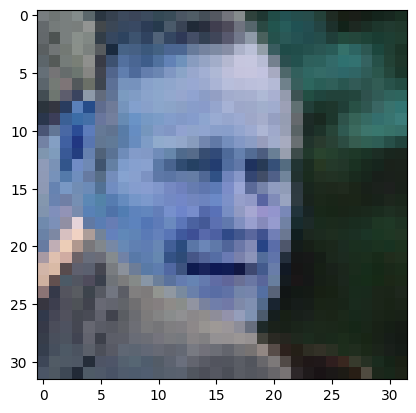

In [22]:
import matplotlib.pyplot as plt
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))
show_image(X[6])

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(X, test_size=0.1, random_state=42)
print(x_train.shape)
print(x_test.shape)

(11828, 32, 32, 3)
(1315, 32, 32, 3)


### Implementing the Autoencoder

In [87]:
latent_dim = 2
img_shape = X.shape[1:]
class Autoencoder(Model):
    def __init__(self,latent_dim):
        super(Autoencoder,self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim,activation='relu'),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(np.prod(img_shape),activation='sigmoid'),
            layers.Reshape(img_shape)                                  
        ])
    def call(self,x):
        encoded=self.encoder(x)
        decoded=self.decoder(encoded)
        return decoded
autoencoder=Autoencoder(latent_dim)

In [88]:
autoencoder.compile(optimizer='adamax',loss=losses.MeanSquaredError())


### Model training

In [89]:
history = autoencoder.fit(x_train,x_train,epochs=20,shuffle=True,
                          validation_data=(x_test,x_test))

Epoch 1/20
370/370 [==============================] - 1s 2ms/step - loss: 0.1421 - val_loss: 0.0794
Epoch 2/20
370/370 [==============================] - 1s 1ms/step - loss: 0.0769 - val_loss: 0.0746
Epoch 3/20
370/370 [==============================] - 1s 1ms/step - loss: 0.0747 - val_loss: 0.0734
Epoch 4/20
370/370 [==============================] - 1s 1ms/step - loss: 0.0739 - val_loss: 0.0727
Epoch 5/20
370/370 [==============================] - 1s 2ms/step - loss: 0.0733 - val_loss: 0.0722
Epoch 6/20
370/370 [==============================] - 1s 1ms/step - loss: 0.0729 - val_loss: 0.0718
Epoch 7/20
370/370 [==============================] - 1s 1ms/step - loss: 0.0726 - val_loss: 0.0715
Epoch 8/20
370/370 [==============================] - 1s 1ms/step - loss: 0.0723 - val_loss: 0.0713
Epoch 9/20
370/370 [==============================] - 1s 1ms/step - loss: 0.0722 - val_loss: 0.0712
Epoch 10/20
370/370 [==============================] - 1s 1ms/step - loss: 0.0720 - val_loss: 0.0711

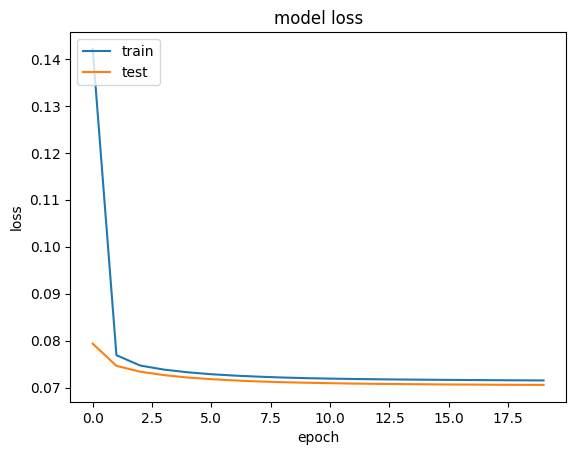

In [90]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 29ms/step


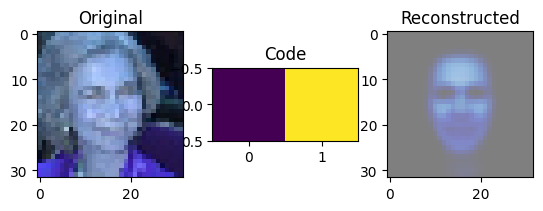

1/1 [==============================] - 0s 12ms/step


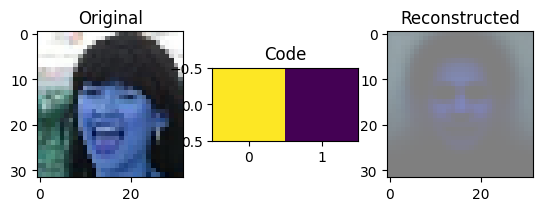

1/1 [==============================] - 0s 13ms/step


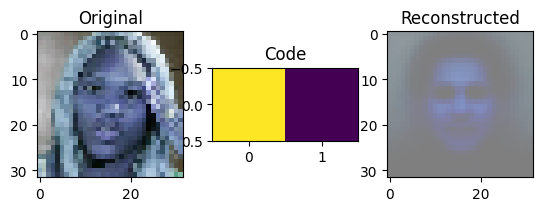

1/1 [==============================] - 0s 12ms/step


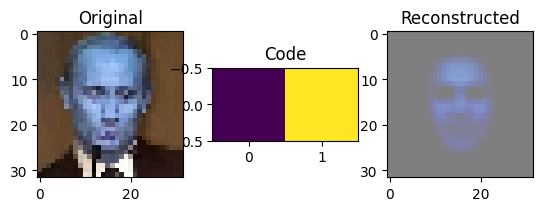

1/1 [==============================] - 0s 12ms/step


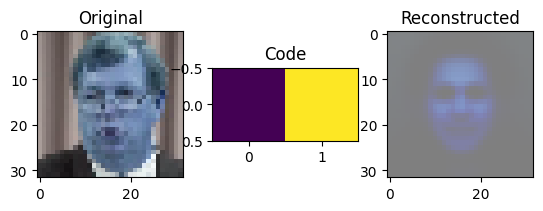

In [91]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

for i in range(5):
    img = x_test[i]
    visualize(img,autoencoder.encoder,autoencoder.decoder)

In [95]:
import sys
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def show_image(img, ax=None):
    """Helper function to display an image with a consistent colormap"""
    if ax is None:
        ax = plt.gca()
    ax.imshow(img, cmap='gray')
    ax.axis('off')

def visualize(img, encoder, decoder):
    """Draws original, encoded and decoded images and returns the plot figure"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Encode and decode the image
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]
    
    # Original image
    axes[0].set_title("Original")
    show_image(img, ax=axes[0])
    
    # Encoded image
    axes[1].set_title("Code")
    axes[1].imshow(code.reshape([code.shape[-1]//2, -1]), cmap='gray')
    axes[1].axis('off')
    
    # Reconstructed image
    axes[2].set_title("Reconstructed")
    show_image(reco, ax=axes[2])
    
    return fig

# Redirect stdout to capture print statements
original_stdout = sys.stdout
with open('output.txt', 'w') as f:
    sys.stdout = f
    
    # Create a PDF to save the plots
    with PdfPages('autoencoder_visualizations.pdf') as pdf:
        for i in range(5):
            img = x_test[i]
            fig = visualize(img, autoencoder.encoder, autoencoder.decoder)
            pdf.savefig(fig, bbox_inches='tight')  # Save with tight bounding box
            plt.close(fig)
    
    print("Visualizations saved to autoencoder_visualizations.pdf")
    
    # Reset stdout to its original state
    sys.stdout = original_stdout

print("Output and visualizations saved successfully.")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
